# Oppenheimer or Barbie?

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
import keras

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.layers import Dense, Input
from keras.optimizers import SGD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

## Data

In [4]:
df_bb = pd.read_csv('./data/imdb_barbie_Uncleaned.csv', header=None)
df_op = pd.read_csv('./data/imdb_oppenhimmer_Uncleaned.csv', header=None)
df_bb.drop_duplicates(inplace=True)
df_op.drop_duplicates(inplace=True)

## Data Cleaning

In [5]:
import re

score_Reg = '(\d{1,2})\/\d{1,2}\s.*\s'
title_Reg = '\d{1,2}\/\d{1,2}\s(.*)'
people_found_helpful_Reg = '([\d,]*) out of ([\d,]*) found this helpful'
username_Reg = '\d{1,2}\/\d{1,2}\s.*\s([A-Za-z0-9_-]+)\d{2}\s[January|February|March|April|June|July|August|September|October|November|December]'
date_Reg = '(\d{1,2}\s\w+\s\d{4})'
review_Reg = '\d{1,2}\s\w+\s\d{4}\s([\s\S]*)\s[\d,]* out of [\d,]* found this helpful'

In [6]:
# Clean every row in data set

def get_cleaned_df(dirty_df):
    # cleaned_df = pd.DataFrame(columns=['score', 'title', 'username', 'date', 'people_found_helpful', 'review'])
    cleaned_df = pd.DataFrame(columns=['score', 'title', 'username', 'date', 'people_found_helpful', 'total_people_viewed', 'review'])

    for index in range(len(dirty_df)):
        row = dirty_df.iloc[index][0]

        score = re.findall(score_Reg, row)
        title = re.findall(title_Reg, row)
        username = re.findall(username_Reg, row)
        date = re.findall(date_Reg, row)
        people_found_helpful = re.findall(people_found_helpful_Reg, row)
        review = re.findall(review_Reg, row)

        if not score:
            continue
        else:
            score = int(score[0])
        if not title:
            title = ['NULL']
        if not username:
            username = ['NULL']
        if not date:
            date = ['NULL']
        if not people_found_helpful:
            people_found_helpful = 'NULL'
            total_people_viewed = 'NULL'
        else:
            total_people_viewed = int(people_found_helpful[0][1].replace(',', ''))
            people_found_helpful = int(people_found_helpful[0][0].replace(',', ''))
        if not review:
            review = ['NULL']

        cleaned_df.loc[index] = [score, title[0], username[0], date[0], people_found_helpful, total_people_viewed, review[0]]
    return cleaned_df


In [7]:
cleand_df_bb = get_cleaned_df(df_bb)
cleand_df_bb.drop_duplicates(subset=['username'], inplace=True)

In [8]:
cleand_df_op = get_cleaned_df(df_op)
cleand_df_op.drop_duplicates(subset=['username'], inplace=True)

In [9]:
cleand_df_bb

,score,title,username,date,people_found_helpful,total_people_viewed,review
0,6,Creative but preachy and confusing,Imshortok06,23 July 2023,1007,1363,I'm just going to get straight to the point: I...
1,6,"Beautiful film, but so preachy",LoveofLegacy,21 July 2023,1190,1646,"Margot does the best with what she's given, bu..."
2,6,Clever and fun beginning turns into another le...,Binkconn,21 July 2023,804,1173,"Barbie begins in an irresistible way, as a fun..."
3,8,It was depressing,coxaneesa,24 July 2023,152,242,Warning: Spoilers
4,9,A Technicolor Dream,heatherhilgers,24 July 2023,20,26,"Wow, this movie was a love letter to cinema. F..."
...,...,...,...,...,...,...,...
792,2,Barbie-not good,thongman,22 July 2023,5,17,The only reason this movie even gets a 2 from ...
793,5,Feminism but the rest?,iyaseminkose,23 July 2023,1,6,"I'm NOT a Barbie girl in NOT the Barbie World,..."
794,3,"Great sets, great execution but horrible story...",DaHermitKid,28 July 2023,1,5,"Firstly, the technical execution is top notch...."
795,2,Just meh.,apriljosey-29034,27 July 2023,0,1,Warning: Spoilers


In [10]:
cleand_df_op

,score,title,username,date,people_found_helpful,total_people_viewed,review
0,9,Murphy is exceptional,Orlando_Gardner,19 July 2023,1413,1597,You'll have to have your wits about you and yo...
1,8,"A challenging watch to be sure, but a worthwhi...",Jeremy_Urquhart,20 July 2023,685,819,One of the most anticipated films of the year ...
2,10,A brilliantly layered examination of a man thr...,MrDHWong,20 July 2023,556,691,"""Oppenheimer"" is a biographical thriller film ..."
3,10,Nolan delivers a powerfull biopic that shows t...,and_mikkelsen,20 July 2023,358,457,This movie is just... wow! I don't think I hav...
4,10,A Masterpiece,mohameddawoud-26019,19 July 2023,670,833,I may consider myself lucky to be alive to wat...
...,...,...,...,...,...,...,...
2031,7,"Huge story, but production fails sometimes",andreverschoor,27 July 2023,1,3,"Loved the movie, loved the actors efforts. Aft..."
2032,6,Tweaked,fmacr,25 July 2023,1,7,"I suppose these reviews are tweaked, otherwise..."
2033,6,Just a 6 for a near perfect film.,m-nicolaou-86-661254,24 July 2023,0,1,Ok let me start by the obvious ratings which w...
2034,6,No need to be 3 hours,scottahaynie,24 July 2023,0,0,Acting was tremendous and the true story behin...


In [11]:
cleand_df_bb['isBarbie'] = 1
cleand_df_op['isBarbie'] = 0

df = pd.concat([cleand_df_bb, cleand_df_op], ignore_index=True)

## Data Exploration

In [12]:
# Creating graphable data
df = df[~df['date'].str.contains('IMAX')]
# numeric_df = pd.DataFrame(columns=['isBarbie', 'score', 'people_found_helpful', 'total_people_viewed', 'helpful_ratio', 'date', 'date_from_release','length_of_title', 'length_of_username', 'length_of_review'])
numeric_df = pd.DataFrame(columns=['isBarbie', 'score', 'date', 'people_found_helpful', 'total_people_viewed', 'helpful_ratio','length_of_title', 'length_of_username', 'length_of_review'])

numeric_df['isBarbie'] = df['isBarbie']
numeric_df['score'] = df['score']
numeric_df['date'] = df['date']
numeric_df['total_people_viewed'] = df['total_people_viewed']
numeric_df['people_found_helpful'] = df['people_found_helpful']
numeric_df['helpful_ratio'] = df['people_found_helpful'] / df['total_people_viewed']
numeric_df['length_of_title'] = df['title'].apply(lambda x: len(x))
numeric_df['length_of_username'] = df['username'].apply(lambda x: len(x))
numeric_df['length_of_review'] = df['review'].apply(lambda x: len(x))

numeric_df['date'] = pd.to_datetime(df['date'], format='%d %B %Y')
numeric_df['date_from_release'] = (numeric_df['date'] - pd.to_datetime('2023-07-23', format='%Y-%m-%d')).dt.days

In [13]:
numeric_df

,isBarbie,score,date,people_found_helpful,total_people_viewed,helpful_ratio,length_of_title,length_of_username,length_of_review,date_from_release
0,1,6,2023-07-23,1007,1363,0.738811,34,11,1216,0
1,1,6,2023-07-21,1190,1646,0.722965,30,12,786,-2
2,1,6,2023-07-21,804,1173,0.685422,69,8,601,-2
3,1,8,2023-07-24,152,242,0.628099,17,9,17,1
4,1,9,2023-07-24,20,26,0.769231,19,14,1239,1
...,...,...,...,...,...,...,...,...,...,...
2792,0,7,2023-07-27,1,3,0.333333,42,14,624,4
2793,0,6,2023-07-25,1,7,0.142857,7,5,1152,2
2794,0,6,2023-07-24,0,1,0.000000,33,20,1369,1
2795,0,6,2023-07-24,0,0,NaN,21,12,609,1


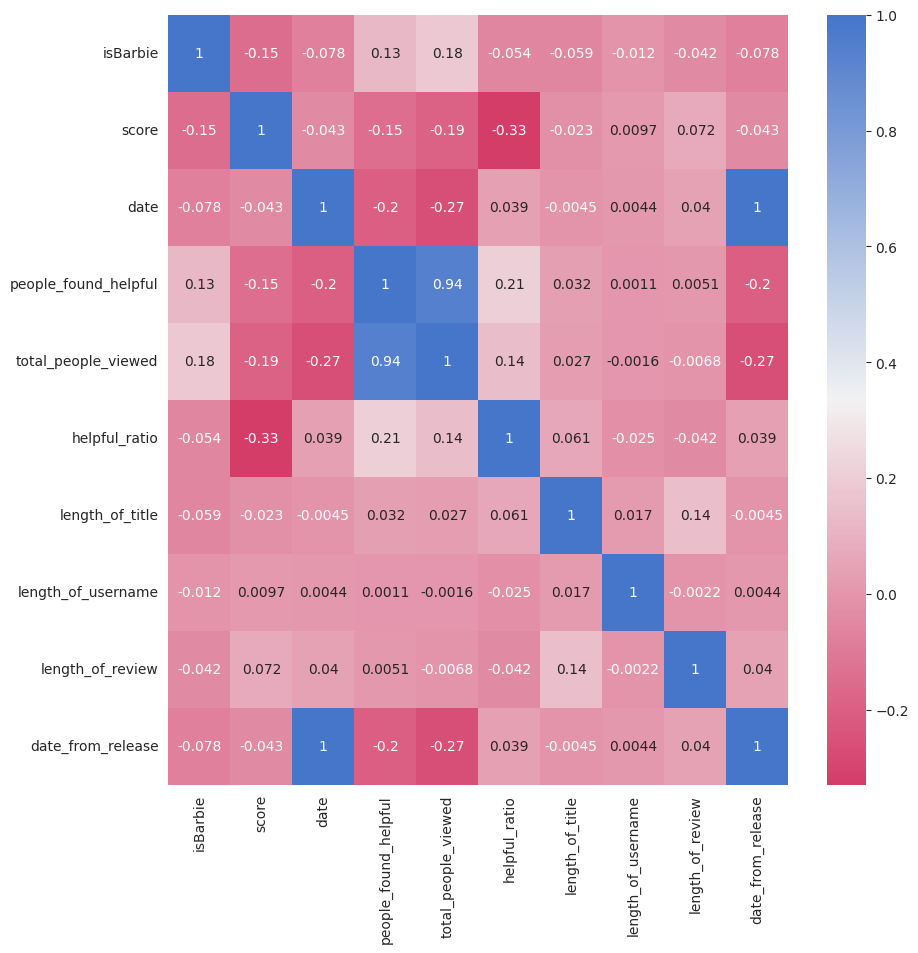

In [14]:
# Coorelation Matrix

drop_na_df = numeric_df[numeric_df['score'] != 'NULL']

fig1 = plt.figure(figsize=(10, 10))
ax1 = fig1.add_subplot(111)

cmap = sns.diverging_palette(0, 255, n=256, as_cmap=True)

sns.heatmap(data=drop_na_df.corr(), ax=ax1, cmap=cmap, annot=True)

plt.show()

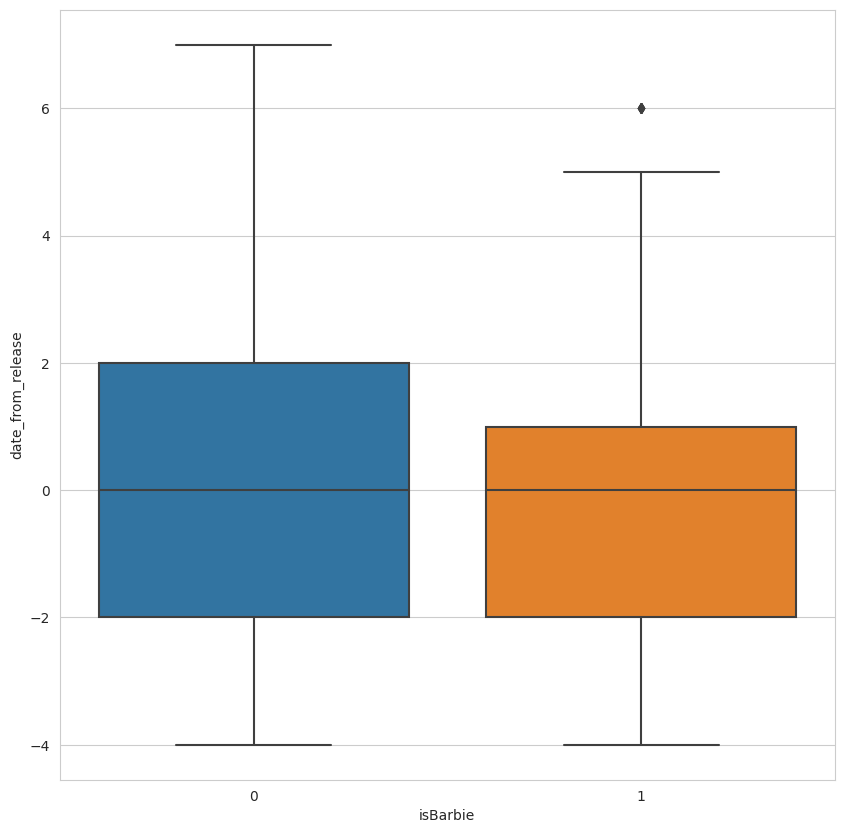

In [15]:
fig2 = plt.figure(figsize=(10, 10))
ax2 = fig2.add_subplot(111)

sns.boxplot(data=numeric_df, x='isBarbie', y='date_from_release', ax=ax2)

plt.show()

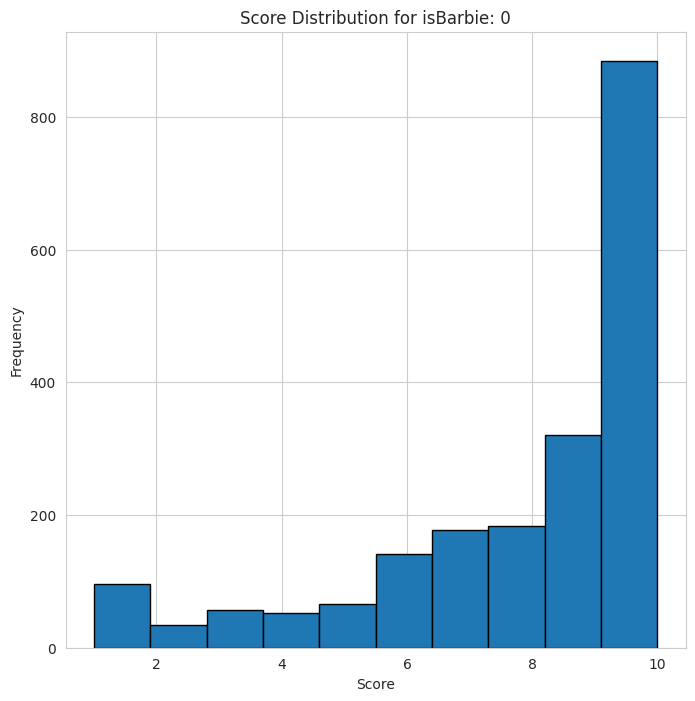

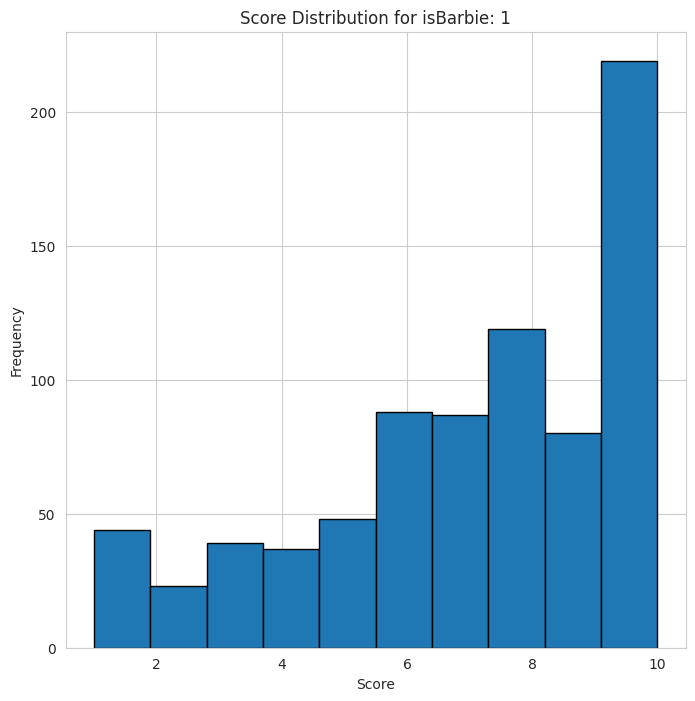

In [16]:
group_by = df.groupby('isBarbie')
for movie_id, group_data in group_by:
    plt.figure(figsize=(8, 8))
    plt.hist(group_data['score'], edgecolor='black')
    plt.title(f'Score Distribution for isBarbie: {movie_id}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

In [17]:
textdata = df[['review', 'title', 'isBarbie']]
textdata.drop()
textdata

ValueError: Need to specify at least one of 'labels', 'index' or 'columns'

## Modeling

### BERT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(textdata.drop(columns = ['isBarbie', 'title']), textdata['isBarbie'], stratify=textdata['isBarbie'], test_size = 0.2, random_state = 42)

In [ ]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
# BERT layers
text_input = Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = Dense(1, activation='sigmoid')(l)

# Use inputs and outputs to construct a final model
bert_model = tf.keras.Model(inputs=[text_input], outputs = [l])

bert_model.compile(optimizer = Adam(learning_rate = 0.2), loss = 'binary_crossentropy', metrics = ['accuracy'])

bert_history = bert_model.fit(X_train, y_train, batch_size = 64, epochs = 10)

### Bag of Words

In [ ]:
reviews = textdata["review"]

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(reviews)

bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = pd.concat([bow_df, textdata["isBarbie"]], axis=1)

In [ ]:
X = final_df.drop("isBarbie", axis=1)
y = final_df["isBarbie"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)

### ANN

In [ ]:
# Calculates the number of instances the word "Oppenheimer" was used
opp_inst = []
from collections import Counter
for i in range(len(df['review'])):
    count = Counter(df['review'][i].split())
    amount = count['Oppenheimer'] + count['oppenheimer']
    opp_inst.append(amount)

# Calculates the number of instances the word "Barbie" was used
barbie_inst = []
from collections import Counter
for i in range(len(df['review'])):
    count = Counter(df['review'][i].split())
    amount = count['Barbie'] + count['barbie']
    barbie_inst.append(amount)

# Calculates the number of instances the word "movie" was used
movie_inst = []
from collections import Counter
for i in range(len(df['review'])):
    count = Counter(df['review'][i].split())
    amount = count['Movie'] + count['movie']
    movie_inst.append(amount)

# Calculates the number of instances an exclamation mark was used
excl_inst = []
from collections import Counter
for i in range(len(df['review'])):
    count = Counter(df['review'][i])
    amount = count['!']
    excl_inst.append(amount)

new_df = pd.DataFrame()
new_df['opp_inst'] = opp_inst
new_df['barbie_inst'] = barbie_inst
new_df['movie_inst'] = movie_inst
new_df['excl_inst'] = excl_inst
new_df['score'] = numeric_df['score']
new_df['date_from_release'] = numeric_df['date_from_release']
new_df['isBarbie'] = numeric_df['isBarbie']

In [ ]:
# Shuffles samples
new_df = new_df.sample(frac = 1)
new_df

In [ ]:
x_data = new_df.iloc[:,:6]

In [ ]:
scaler = MinMaxScaler()
normalized_inputs = pd.DataFrame(scaler.fit_transform(x_data), columns = x_data.columns)
normalized_inputs

In [ ]:
y_data = new_df['isBarbie']

In [ ]:
classifier = Sequential() # Initialising the ANN

classifier.add(Dense(units = 16, activation = 'sigmoid', input_dim = 6))
classifier.add(Dense(units = 8, activation = 'sigmoid'))
classifier.add(Dense(units = 4, activation = 'sigmoid'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-03)
classifier.compile(optimizer = opt,loss = 'binary_crossentropy')

In [ ]:
x_train, x_test = train_test_split(normalized_inputs, test_size=0.1, random_state=36)
y_train, y_test = train_test_split(y_data, test_size=0.1, random_state=36)

In [ ]:
history = classifier.fit(x_train, y_train, batch_size = 30, epochs = 100)

## Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier

estimator = [('bert', bert_model), ('ann', classifier), ('tree', clf)]

ensemble = VotingClassifier(estimators=estimator, voting='hard')

ensemble.fit(x_train, y_train)

ensemble_prediction = ensemble.predict(x_test)

In [ ]:
ensemble.score(x_test, y_test)